In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
tf.__version__

'2.17.0'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

Reading Data

In [6]:
PATH = os.getcwd()
data_dir = PATH + "\\grading_data"
print(data_dir)

D:\major_project_1\grading_data


In [7]:
batch_size = 32
img_height = 528
img_width = 652

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    seed=123,
    batch_size=batch_size,
)

Found 600 files belonging to 3 classes.
Using 480 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    seed=123,
    batch_size=batch_size,
)

Found 600 files belonging to 3 classes.
Using 120 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['A Grade', 'B Grade', 'C Grade']


2024-09-04 09:21:34.253493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


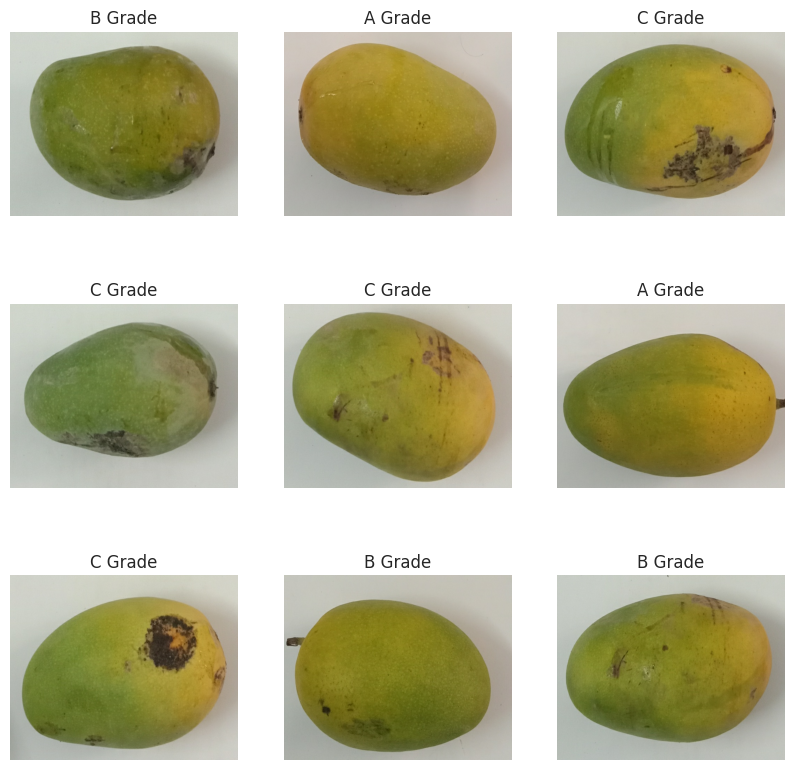

In [134]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        aax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')


In [135]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 528, 652, 3)
(32,)


In [136]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

Preprocessing Images

In [12]:
def preprocess_image(image, label):
    image = tf.image.resize(image, [224, 224], method=tf.image.ResizeMethod.BILINEAR, antialias=True)
    return image, label

In [146]:
train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Model Declaration

In [97]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [98]:
base_model = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
len(list(base_model.layers))

187

In [99]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(8)

In [100]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [101]:
base_learning_rate = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [102]:
# tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [103]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │         7,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,004,040 (11.46 MB)

 Trainable params: 7,688 (30.03 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [104]:
initial_epochs = 10

In [105]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    )

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.1341 - loss: 3.1143 - val_accuracy: 0.4750 - val_loss: 1.1636
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.5211 - loss: 1.1635 - val_accuracy: 0.6083 - val_loss: 0.8870
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.5619 - loss: 0.9852 - val_accuracy: 0.6167 - val_loss: 0.7703
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.5892 - loss: 0.8596 - val_accuracy: 0.7083 - val_loss: 0.6863
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.6413 - loss: 0.7107 - val_accuracy: 0.7500 - val_loss: 0.6350
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6942 - loss: 0.6761 - val_accuracy: 0.7750 - val_loss: 0.5894
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.7468 - loss: 0.5774 - val_accuracy: 0.8083 - val_loss: 0.5574
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.7708 - loss: 0.5808 - val_accuracy: 0.8083 - 

Tuning Model

In [106]:
base_model.trainable = True

fine_tune_at = 174

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [107]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
    metrics=['accuracy'],
)

In [108]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │         7,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,004,040 (11.46 MB)

 Trainable params: 779,128 (2.97 MB)

 Non-trainable params: 2,224,912 (8.49 MB)

In [109]:
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,)

Epoch 10/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.4914 - loss: 1.2649 - val_accuracy: 0.7500 - val_loss: 0.5748
Epoch 11/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.7774 - loss: 0.5450 - val_accuracy: 0.6667 - val_loss: 0.6676
Epoch 12/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.8554 - loss: 0.3795 - val_accuracy: 0.6667 - val_loss: 0.6886
Epoch 13/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.8870 - loss: 0.3444 - val_accuracy: 0.6917 - val_loss: 0.6582
Epoch 14/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.8980 - loss: 0.3159 - val_accuracy: 0.7083 - val_loss: 0.6220
Epoch 15/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9040 - loss: 0.2855 - val_accuracy: 0.7167 - val_loss: 0.5956
Epoch 16/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.9095 - loss: 0.2517 - val_accuracy: 0.7500 - val_loss: 0.5638
Epoch 17/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9393 - loss: 0.2321 - val_accu

Predictions:
 [0 1 1 0 2 0 0 0 2 2 1 0 1 0 1 1 2 1 1 0 1 2 0 2 2 0 0 2 1 1 0 1]
Labels:
 [0 1 1 0 2 0 1 0 2 2 1 0 1 0 1 1 2 1 1 0 1 2 0 2 2 0 0 2 1 1 0 1]


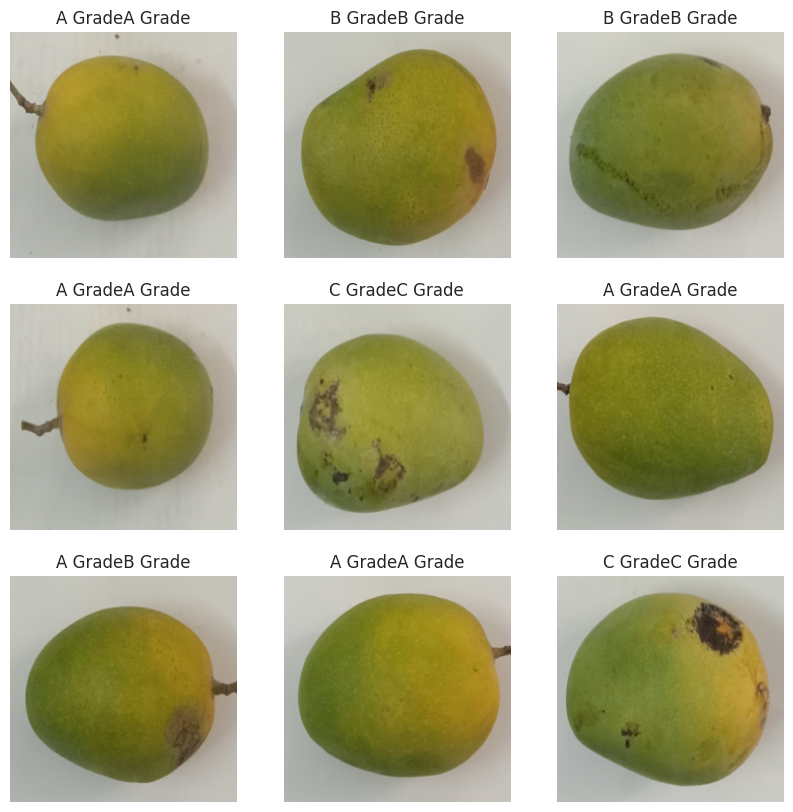

In [147]:
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)


predictions = tf.nn.softmax(predictions, axis=-1)
predicted_classes = tf.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_classes.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predicted_classes[i]] + class_names[label_batch[i]])
    plt.axis("off")

plt.show()

ValueError: not enough values to unpack (expected 2, got 1)

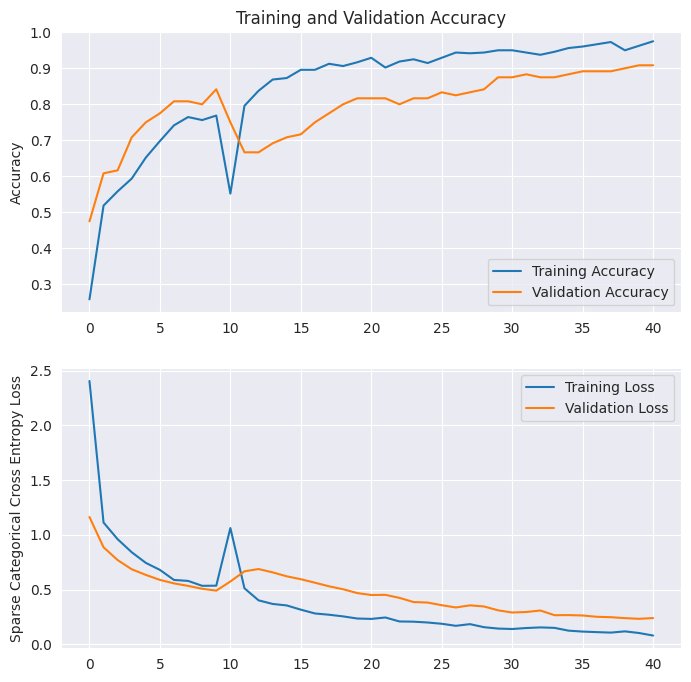

In [148]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim(min(plt.ylim()), 1)
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Sparse Categorical Cross Entropy Loss')
plt.ylim([[0, 1.0]])
plt.title("Training and Validation Loss")
plt.xlabel('epoch')
plt.show()

In [149]:
# Confusion Matrix
cm = tf.math.confusion_matrix(label_batch, predicted_classes)

In [150]:
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[11,  0,  0],
       [ 1, 12,  0],
       [ 0,  0,  8]], dtype=int32)>

In [151]:
cm_np = cm.numpy()

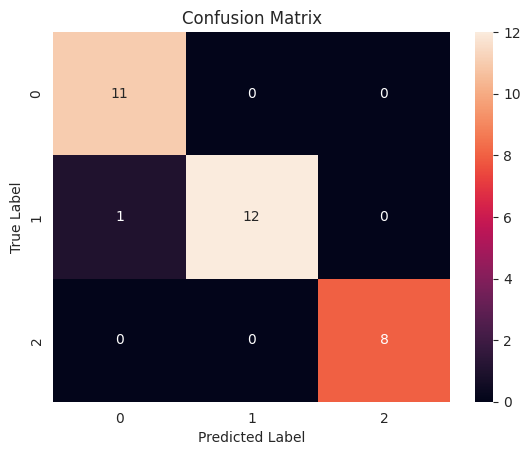

In [152]:
sns.heatmap(cm_np, annot=True)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix")
plt.show()

In [153]:
model.save(os.getcwd() + '/models/grading.keras')

In [2]:
m2 = tf.keras.models.load_model(os.getcwd() + '/models/grading.keras')

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'functional_13', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_19'}, 'registered_name': None, 'name': 'input_layer_19', 'inbound_nodes': []}, {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_20'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'RandomFlip', 'config': {'name': 'random_flip_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'seed': None, 'mode': 'horizontal_and_vertical'}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}}, {'module': 'keras.layers', 'class_name': 'RandomRotation', 'config': {'name': 'random_rotation_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'factor': [-0.2, 0.2], 'value_range': [0, 255], 'data_format': 'channels_last', 'fill_mode': 'reflect', 'fill_value': 0.0, 'interpolation': 'bilinear', 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}}], 'build_input_shape': [None, 224, 224, 3]}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'sequential_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 3], 'dtype': 'float32', 'keras_history': ['input_layer_19', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'MobileNetV3Large', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_18'}, 'registered_name': None, 'name': 'input_layer_18', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Rescaling', 'config': {'name': 'rescaling_6', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'scale': 0.00784313725490196, 'offset': -1.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'rescaling_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 3], 'dtype': 'float32', 'keras_history': ['input_layer_18', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 16, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 3], 'dtype': 'float32', 'keras_history': ['rescaling_6', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 'conv_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 16], 'dtype': 'float32', 'keras_history': ['conv', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_120', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 'activation_120', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 16], 'dtype': 'float32', 'keras_history': ['conv_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_depthwise', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'depth_multiplier': 1, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 'expanded_conv_depthwise', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 16], 'dtype': 'float32', 'keras_history': ['activation_120', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_depthwise_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 'expanded_conv_depthwise_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 16], 'dtype': 'float32', 'keras_history': ['expanded_conv_depthwise', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_114', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 're_lu_114', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 16], 'dtype': 'float32', 'keras_history': ['expanded_conv_depthwise_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_project', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 16, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 'expanded_conv_project', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 16], 'dtype': 'float32', 'keras_history': ['re_lu_114', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_project_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 'expanded_conv_project_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 16], 'dtype': 'float32', 'keras_history': ['expanded_conv_project', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_add', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 112, 112, 16], [None, 112, 112, 16]]}, 'name': 'expanded_conv_add', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 16], 'dtype': 'float32', 'keras_history': ['activation_120', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 16], 'dtype': 'float32', 'keras_history': ['expanded_conv_project_bn', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_1_expand', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 'expanded_conv_1_expand', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 16], 'dtype': 'float32', 'keras_history': ['expanded_conv_add', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_1_expand_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 64]}, 'name': 'expanded_conv_1_expand_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 64], 'dtype': 'float32', 'keras_history': ['expanded_conv_1_expand', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_115', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 64]}, 'name': 're_lu_115', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 64], 'dtype': 'float32', 'keras_history': ['expanded_conv_1_expand_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'expanded_conv_1_depthwise_pad', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 64]}, 'name': 'expanded_conv_1_depthwise_pad', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 64], 'dtype': 'float32', 'keras_history': ['re_lu_115', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_1_depthwise', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'depth_multiplier': 1, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 113, 113, 64]}, 'name': 'expanded_conv_1_depthwise', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 113, 113, 64], 'dtype': 'float32', 'keras_history': ['expanded_conv_1_depthwise_pad', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_1_depthwise_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'expanded_conv_1_depthwise_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 64], 'dtype': 'float32', 'keras_history': ['expanded_conv_1_depthwise', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_116', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 're_lu_116', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 64], 'dtype': 'float32', 'keras_history': ['expanded_conv_1_depthwise_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_1_project', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'expanded_conv_1_project', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 64], 'dtype': 'float32', 'keras_history': ['re_lu_116', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_1_project_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 24]}, 'name': 'expanded_conv_1_project_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 24], 'dtype': 'float32', 'keras_history': ['expanded_conv_1_project', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_2_expand', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 72, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 24]}, 'name': 'expanded_conv_2_expand', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 24], 'dtype': 'float32', 'keras_history': ['expanded_conv_1_project_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_2_expand_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 'expanded_conv_2_expand_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 72], 'dtype': 'float32', 'keras_history': ['expanded_conv_2_expand', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_117', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 're_lu_117', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 72], 'dtype': 'float32', 'keras_history': ['expanded_conv_2_expand_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_2_depthwise', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'depth_multiplier': 1, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 'expanded_conv_2_depthwise', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 72], 'dtype': 'float32', 'keras_history': ['re_lu_117', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_2_depthwise_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 'expanded_conv_2_depthwise_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 72], 'dtype': 'float32', 'keras_history': ['expanded_conv_2_depthwise', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_118', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 're_lu_118', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 72], 'dtype': 'float32', 'keras_history': ['expanded_conv_2_depthwise_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_2_project', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 'expanded_conv_2_project', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 72], 'dtype': 'float32', 'keras_history': ['re_lu_118', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_2_project_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 24]}, 'name': 'expanded_conv_2_project_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 24], 'dtype': 'float32', 'keras_history': ['expanded_conv_2_project', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_2_add', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 56, 56, 24], [None, 56, 56, 24]]}, 'name': 'expanded_conv_2_add', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 24], 'dtype': 'float32', 'keras_history': ['expanded_conv_1_project_bn', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 24], 'dtype': 'float32', 'keras_history': ['expanded_conv_2_project_bn', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_3_expand', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 72, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 24]}, 'name': 'expanded_conv_3_expand', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 24], 'dtype': 'float32', 'keras_history': ['expanded_conv_2_add', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_3_expand_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 'expanded_conv_3_expand_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 72], 'dtype': 'float32', 'keras_history': ['expanded_conv_3_expand', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_119', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 're_lu_119', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 72], 'dtype': 'float32', 'keras_history': ['expanded_conv_3_expand_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'expanded_conv_3_depthwise_pad', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'padding': [[1, 2], [1, 2]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 'expanded_conv_3_depthwise_pad', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 72], 'dtype': 'float32', 'keras_history': ['re_lu_119', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_3_depthwise', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'depth_multiplier': 1, 'kernel_size': [5, 5], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 59, 59, 72]}, 'name': 'expanded_conv_3_depthwise', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 59, 59, 72], 'dtype': 'float32', 'keras_history': ['expanded_conv_3_depthwise_pad', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_3_depthwise_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 72]}, 'name': 'expanded_conv_3_depthwise_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 72], 'dtype': 'float32', 'keras_history': ['expanded_conv_3_depthwise', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_120', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 72]}, 'name': 're_lu_120', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 72], 'dtype': 'float32', 'keras_history': ['expanded_conv_3_depthwise_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'expanded_conv_3_squeeze_excite_avg_pool', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'data_format': 'channels_last', 'keepdims': True}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 72]}, 'name': 'expanded_conv_3_squeeze_excite_avg_pool', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 72], 'dtype': 'float32', 'keras_history': ['re_lu_120', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_3_squeeze_excite_conv', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 72]}, 'name': 'expanded_conv_3_squeeze_excite_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 72], 'dtype': 'float32', 'keras_history': ['expanded_conv_3_squeeze_excite_avg_pool', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_3_squeeze_excite_relu', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 24]}, 'name': 'expanded_conv_3_squeeze_excite_relu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 24], 'dtype': 'float32', 'keras_history': ['expanded_conv_3_squeeze_excite_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_3_squeeze_excite_conv_1', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 72, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 24]}, 'name': 'expanded_conv_3_squeeze_excite_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 24], 'dtype': 'float32', 'keras_history': ['expanded_conv_3_squeeze_excite_relu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_48'}, 'registered_name': 'Add', 'name': 'add_48', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 72], 'dtype': 'float32', 'keras_history': ['expanded_conv_3_squeeze_excite_conv_1', 0, 0]}}, 3.0], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_121', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 72]}, 'name': 're_lu_121', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 72], 'dtype': 'float32', 'keras_history': ['add_48', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Multiply', 'config': {'name': 'multiply_48'}, 'registered_name': 'Multiply', 'name': 'multiply_48', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 72], 'dtype': 'float32', 'keras_history': ['re_lu_121', 0, 0]}}, 0.16666666666666666], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'expanded_conv_3_squeeze_excite_mul', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 72], [None, 1, 1, 72]]}, 'name': 'expanded_conv_3_squeeze_excite_mul', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 72], 'dtype': 'float32', 'keras_history': ['re_lu_120', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 72], 'dtype': 'float32', 'keras_history': ['multiply_48', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_3_project', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 40, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 72]}, 'name': 'expanded_conv_3_project', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 72], 'dtype': 'float32', 'keras_history': ['expanded_conv_3_squeeze_excite_mul', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_3_project_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 40]}, 'name': 'expanded_conv_3_project_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 40], 'dtype': 'float32', 'keras_history': ['expanded_conv_3_project', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_4_expand', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 120, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 40]}, 'name': 'expanded_conv_4_expand', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 40], 'dtype': 'float32', 'keras_history': ['expanded_conv_3_project_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_4_expand_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_4_expand_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 120], 'dtype': 'float32', 'keras_history': ['expanded_conv_4_expand', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_122', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 're_lu_122', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 120], 'dtype': 'float32', 'keras_history': ['expanded_conv_4_expand_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_4_depthwise', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'depth_multiplier': 1, 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_4_depthwise', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 120], 'dtype': 'float32', 'keras_history': ['re_lu_122', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_4_depthwise_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_4_depthwise_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 120], 'dtype': 'float32', 'keras_history': ['expanded_conv_4_depthwise', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_123', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 're_lu_123', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 120], 'dtype': 'float32', 'keras_history': ['expanded_conv_4_depthwise_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'expanded_conv_4_squeeze_excite_avg_pool', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'data_format': 'channels_last', 'keepdims': True}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_4_squeeze_excite_avg_pool', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 120], 'dtype': 'float32', 'keras_history': ['re_lu_123', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_4_squeeze_excite_conv', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 120]}, 'name': 'expanded_conv_4_squeeze_excite_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 120], 'dtype': 'float32', 'keras_history': ['expanded_conv_4_squeeze_excite_avg_pool', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_4_squeeze_excite_relu', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 32]}, 'name': 'expanded_conv_4_squeeze_excite_relu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 32], 'dtype': 'float32', 'keras_history': ['expanded_conv_4_squeeze_excite_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_4_squeeze_excite_conv_1', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 120, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 32]}, 'name': 'expanded_conv_4_squeeze_excite_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 32], 'dtype': 'float32', 'keras_history': ['expanded_conv_4_squeeze_excite_relu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_49'}, 'registered_name': 'Add', 'name': 'add_49', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 120], 'dtype': 'float32', 'keras_history': ['expanded_conv_4_squeeze_excite_conv_1', 0, 0]}}, 3.0], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_124', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 120]}, 'name': 're_lu_124', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 120], 'dtype': 'float32', 'keras_history': ['add_49', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Multiply', 'config': {'name': 'multiply_49'}, 'registered_name': 'Multiply', 'name': 'multiply_49', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 120], 'dtype': 'float32', 'keras_history': ['re_lu_124', 0, 0]}}, 0.16666666666666666], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'expanded_conv_4_squeeze_excite_mul', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 120], [None, 1, 1, 120]]}, 'name': 'expanded_conv_4_squeeze_excite_mul', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 120], 'dtype': 'float32', 'keras_history': ['re_lu_123', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 120], 'dtype': 'float32', 'keras_history': ['multiply_49', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_4_project', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 40, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_4_project', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 120], 'dtype': 'float32', 'keras_history': ['expanded_conv_4_squeeze_excite_mul', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_4_project_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 40]}, 'name': 'expanded_conv_4_project_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 40], 'dtype': 'float32', 'keras_history': ['expanded_conv_4_project', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_4_add', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 40], [None, 28, 28, 40]]}, 'name': 'expanded_conv_4_add', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 40], 'dtype': 'float32', 'keras_history': ['expanded_conv_3_project_bn', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 40], 'dtype': 'float32', 'keras_history': ['expanded_conv_4_project_bn', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_5_expand', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 120, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 40]}, 'name': 'expanded_conv_5_expand', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 40], 'dtype': 'float32', 'keras_history': ['expanded_conv_4_add', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_5_expand_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_5_expand_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 120], 'dtype': 'float32', 'keras_history': ['expanded_conv_5_expand', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_125', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 're_lu_125', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 120], 'dtype': 'float32', 'keras_history': ['expanded_conv_5_expand_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_5_depthwise', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'depth_multiplier': 1, 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_5_depthwise', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 120], 'dtype': 'float32', 'keras_history': ['re_lu_125', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_5_depthwise_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_5_depthwise_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 120], 'dtype': 'float32', 'keras_history': ['expanded_conv_5_depthwise', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_126', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 're_lu_126', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 120], 'dtype': 'float32', 'keras_history': ['expanded_conv_5_depthwise_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'expanded_conv_5_squeeze_excite_avg_pool', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'data_format': 'channels_last', 'keepdims': True}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_5_squeeze_excite_avg_pool', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 120], 'dtype': 'float32', 'keras_history': ['re_lu_126', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_5_squeeze_excite_conv', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 120]}, 'name': 'expanded_conv_5_squeeze_excite_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 120], 'dtype': 'float32', 'keras_history': ['expanded_conv_5_squeeze_excite_avg_pool', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_5_squeeze_excite_relu', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 32]}, 'name': 'expanded_conv_5_squeeze_excite_relu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 32], 'dtype': 'float32', 'keras_history': ['expanded_conv_5_squeeze_excite_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_5_squeeze_excite_conv_1', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 120, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 32]}, 'name': 'expanded_conv_5_squeeze_excite_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 32], 'dtype': 'float32', 'keras_history': ['expanded_conv_5_squeeze_excite_relu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_50'}, 'registered_name': 'Add', 'name': 'add_50', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 120], 'dtype': 'float32', 'keras_history': ['expanded_conv_5_squeeze_excite_conv_1', 0, 0]}}, 3.0], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_127', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 120]}, 'name': 're_lu_127', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 120], 'dtype': 'float32', 'keras_history': ['add_50', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Multiply', 'config': {'name': 'multiply_50'}, 'registered_name': 'Multiply', 'name': 'multiply_50', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 120], 'dtype': 'float32', 'keras_history': ['re_lu_127', 0, 0]}}, 0.16666666666666666], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'expanded_conv_5_squeeze_excite_mul', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 120], [None, 1, 1, 120]]}, 'name': 'expanded_conv_5_squeeze_excite_mul', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 120], 'dtype': 'float32', 'keras_history': ['re_lu_126', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 120], 'dtype': 'float32', 'keras_history': ['multiply_50', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_5_project', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 40, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_5_project', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 120], 'dtype': 'float32', 'keras_history': ['expanded_conv_5_squeeze_excite_mul', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_5_project_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 40]}, 'name': 'expanded_conv_5_project_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 40], 'dtype': 'float32', 'keras_history': ['expanded_conv_5_project', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_5_add', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 40], [None, 28, 28, 40]]}, 'name': 'expanded_conv_5_add', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 40], 'dtype': 'float32', 'keras_history': ['expanded_conv_4_add', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 40], 'dtype': 'float32', 'keras_history': ['expanded_conv_5_project_bn', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_6_expand', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 240, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 40]}, 'name': 'expanded_conv_6_expand', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 40], 'dtype': 'float32', 'keras_history': ['expanded_conv_5_add', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_6_expand_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 240]}, 'name': 'expanded_conv_6_expand_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 240], 'dtype': 'float32', 'keras_history': ['expanded_conv_6_expand', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_121', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 240]}, 'name': 'activation_121', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 240], 'dtype': 'float32', 'keras_history': ['expanded_conv_6_expand_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'expanded_conv_6_depthwise_pad', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 240]}, 'name': 'expanded_conv_6_depthwise_pad', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 240], 'dtype': 'float32', 'keras_history': ['activation_121', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_6_depthwise', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'depth_multiplier': 1, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 29, 29, 240]}, 'name': 'expanded_conv_6_depthwise', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 29, 29, 240], 'dtype': 'float32', 'keras_history': ['expanded_conv_6_depthwise_pad', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_6_depthwise_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 240]}, 'name': 'expanded_conv_6_depthwise_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 240], 'dtype': 'float32', 'keras_history': ['expanded_conv_6_depthwise', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_122', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 240]}, 'name': 'activation_122', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 240], 'dtype': 'float32', 'keras_history': ['expanded_conv_6_depthwise_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_6_project', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 80, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 240]}, 'name': 'expanded_conv_6_project', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 240], 'dtype': 'float32', 'keras_history': ['activation_122', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_6_project_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 80]}, 'name': 'expanded_conv_6_project_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 80], 'dtype': 'float32', 'keras_history': ['expanded_conv_6_project', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_7_expand', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 200, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 80]}, 'name': 'expanded_conv_7_expand', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 80], 'dtype': 'float32', 'keras_history': ['expanded_conv_6_project_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_7_expand_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 200]}, 'name': 'expanded_conv_7_expand_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 200], 'dtype': 'float32', 'keras_history': ['expanded_conv_7_expand', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_123', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 200]}, 'name': 'activation_123', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 200], 'dtype': 'float32', 'keras_history': ['expanded_conv_7_expand_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_7_depthwise', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'depth_multiplier': 1, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 200]}, 'name': 'expanded_conv_7_depthwise', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 200], 'dtype': 'float32', 'keras_history': ['activation_123', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_7_depthwise_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 200]}, 'name': 'expanded_conv_7_depthwise_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 200], 'dtype': 'float32', 'keras_history': ['expanded_conv_7_depthwise', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_124', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 200]}, 'name': 'activation_124', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 200], 'dtype': 'float32', 'keras_history': ['expanded_conv_7_depthwise_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_7_project', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 80, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 200]}, 'name': 'expanded_conv_7_project', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 200], 'dtype': 'float32', 'keras_history': ['activation_124', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_7_project_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 80]}, 'name': 'expanded_conv_7_project_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 80], 'dtype': 'float32', 'keras_history': ['expanded_conv_7_project', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_7_add', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 80], [None, 14, 14, 80]]}, 'name': 'expanded_conv_7_add', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 80], 'dtype': 'float32', 'keras_history': ['expanded_conv_6_project_bn', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 80], 'dtype': 'float32', 'keras_history': ['expanded_conv_7_project_bn', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_8_expand', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 184, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 80]}, 'name': 'expanded_conv_8_expand', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 80], 'dtype': 'float32', 'keras_history': ['expanded_conv_7_add', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_8_expand_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'expanded_conv_8_expand_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 184], 'dtype': 'float32', 'keras_history': ['expanded_conv_8_expand', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_125', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'activation_125', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 184], 'dtype': 'float32', 'keras_history': ['expanded_conv_8_expand_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_8_depthwise', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'depth_multiplier': 1, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'expanded_conv_8_depthwise', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 184], 'dtype': 'float32', 'keras_history': ['activation_125', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_8_depthwise_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'expanded_conv_8_depthwise_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 184], 'dtype': 'float32', 'keras_history': ['expanded_conv_8_depthwise', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_126', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'activation_126', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 184], 'dtype': 'float32', 'keras_history': ['expanded_conv_8_depthwise_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_8_project', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 80, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'expanded_conv_8_project', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 184], 'dtype': 'float32', 'keras_history': ['activation_126', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_8_project_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 80]}, 'name': 'expanded_conv_8_project_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 80], 'dtype': 'float32', 'keras_history': ['expanded_conv_8_project', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_8_add', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 80], [None, 14, 14, 80]]}, 'name': 'expanded_conv_8_add', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 80], 'dtype': 'float32', 'keras_history': ['expanded_conv_7_add', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 80], 'dtype': 'float32', 'keras_history': ['expanded_conv_8_project_bn', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_9_expand', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 184, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 80]}, 'name': 'expanded_conv_9_expand', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 80], 'dtype': 'float32', 'keras_history': ['expanded_conv_8_add', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_9_expand_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'expanded_conv_9_expand_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 184], 'dtype': 'float32', 'keras_history': ['expanded_conv_9_expand', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_127', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'activation_127', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 184], 'dtype': 'float32', 'keras_history': ['expanded_conv_9_expand_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_9_depthwise', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'depth_multiplier': 1, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'expanded_conv_9_depthwise', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 184], 'dtype': 'float32', 'keras_history': ['activation_127', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_9_depthwise_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'expanded_conv_9_depthwise_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 184], 'dtype': 'float32', 'keras_history': ['expanded_conv_9_depthwise', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_128', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'activation_128', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 184], 'dtype': 'float32', 'keras_history': ['expanded_conv_9_depthwise_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_9_project', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 80, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'expanded_conv_9_project', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 184], 'dtype': 'float32', 'keras_history': ['activation_128', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_9_project_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 80]}, 'name': 'expanded_conv_9_project_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 80], 'dtype': 'float32', 'keras_history': ['expanded_conv_9_project', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_9_add', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 80], [None, 14, 14, 80]]}, 'name': 'expanded_conv_9_add', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 80], 'dtype': 'float32', 'keras_history': ['expanded_conv_8_add', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 80], 'dtype': 'float32', 'keras_history': ['expanded_conv_9_project_bn', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_10_expand', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 480, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 80]}, 'name': 'expanded_conv_10_expand', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 80], 'dtype': 'float32', 'keras_history': ['expanded_conv_9_add', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_10_expand_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 'expanded_conv_10_expand_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 480], 'dtype': 'float32', 'keras_history': ['expanded_conv_10_expand', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_129', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 'activation_129', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 480], 'dtype': 'float32', 'keras_history': ['expanded_conv_10_expand_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_10_depthwise', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'depth_multiplier': 1, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 'expanded_conv_10_depthwise', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 480], 'dtype': 'float32', 'keras_history': ['activation_129', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_10_depthwise_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 'expanded_conv_10_depthwise_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 480], 'dtype': 'float32', 'keras_history': ['expanded_conv_10_depthwise', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_130', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 'activation_130', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 480], 'dtype': 'float32', 'keras_history': ['expanded_conv_10_depthwise_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'expanded_conv_10_squeeze_excite_avg_pool', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'data_format': 'channels_last', 'keepdims': True}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 'expanded_conv_10_squeeze_excite_avg_pool', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 480], 'dtype': 'float32', 'keras_history': ['activation_130', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_10_squeeze_excite_conv', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 120, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 480]}, 'name': 'expanded_conv_10_squeeze_excite_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 480], 'dtype': 'float32', 'keras_history': ['expanded_conv_10_squeeze_excite_avg_pool', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_10_squeeze_excite_relu', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 120]}, 'name': 'expanded_conv_10_squeeze_excite_relu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 120], 'dtype': 'float32', 'keras_history': ['expanded_conv_10_squeeze_excite_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_10_squeeze_excite_conv_1', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 480, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 120]}, 'name': 'expanded_conv_10_squeeze_excite_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 120], 'dtype': 'float32', 'keras_history': ['expanded_conv_10_squeeze_excite_relu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_51'}, 'registered_name': 'Add', 'name': 'add_51', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 480], 'dtype': 'float32', 'keras_history': ['expanded_conv_10_squeeze_excite_conv_1', 0, 0]}}, 3.0], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_128', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 480]}, 'name': 're_lu_128', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 480], 'dtype': 'float32', 'keras_history': ['add_51', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Multiply', 'config': {'name': 'multiply_51'}, 'registered_name': 'Multiply', 'name': 'multiply_51', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 480], 'dtype': 'float32', 'keras_history': ['re_lu_128', 0, 0]}}, 0.16666666666666666], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'expanded_conv_10_squeeze_excite_mul', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 480], [None, 1, 1, 480]]}, 'name': 'expanded_conv_10_squeeze_excite_mul', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 480], 'dtype': 'float32', 'keras_history': ['activation_130', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 480], 'dtype': 'float32', 'keras_history': ['multiply_51', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_10_project', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 112, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 'expanded_conv_10_project', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 480], 'dtype': 'float32', 'keras_history': ['expanded_conv_10_squeeze_excite_mul', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_10_project_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 112]}, 'name': 'expanded_conv_10_project_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 112], 'dtype': 'float32', 'keras_history': ['expanded_conv_10_project', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_11_expand', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 112]}, 'name': 'expanded_conv_11_expand', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 112], 'dtype': 'float32', 'keras_history': ['expanded_conv_10_project_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_11_expand_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'expanded_conv_11_expand_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 672], 'dtype': 'float32', 'keras_history': ['expanded_conv_11_expand', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_131', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'activation_131', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 672], 'dtype': 'float32', 'keras_history': ['expanded_conv_11_expand_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_11_depthwise', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'depth_multiplier': 1, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'expanded_conv_11_depthwise', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 672], 'dtype': 'float32', 'keras_history': ['activation_131', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_11_depthwise_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'expanded_conv_11_depthwise_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 672], 'dtype': 'float32', 'keras_history': ['expanded_conv_11_depthwise', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_132', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'activation_132', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 672], 'dtype': 'float32', 'keras_history': ['expanded_conv_11_depthwise_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'expanded_conv_11_squeeze_excite_avg_pool', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'data_format': 'channels_last', 'keepdims': True}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'expanded_conv_11_squeeze_excite_avg_pool', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 672], 'dtype': 'float32', 'keras_history': ['activation_132', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_11_squeeze_excite_conv', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 168, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 'expanded_conv_11_squeeze_excite_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 672], 'dtype': 'float32', 'keras_history': ['expanded_conv_11_squeeze_excite_avg_pool', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_11_squeeze_excite_relu', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 168]}, 'name': 'expanded_conv_11_squeeze_excite_relu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 168], 'dtype': 'float32', 'keras_history': ['expanded_conv_11_squeeze_excite_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_11_squeeze_excite_conv_1', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 168]}, 'name': 'expanded_conv_11_squeeze_excite_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 168], 'dtype': 'float32', 'keras_history': ['expanded_conv_11_squeeze_excite_relu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_52'}, 'registered_name': 'Add', 'name': 'add_52', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 672], 'dtype': 'float32', 'keras_history': ['expanded_conv_11_squeeze_excite_conv_1', 0, 0]}}, 3.0], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_129', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 're_lu_129', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 672], 'dtype': 'float32', 'keras_history': ['add_52', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Multiply', 'config': {'name': 'multiply_52'}, 'registered_name': 'Multiply', 'name': 'multiply_52', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 672], 'dtype': 'float32', 'keras_history': ['re_lu_129', 0, 0]}}, 0.16666666666666666], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'expanded_conv_11_squeeze_excite_mul', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 672], [None, 1, 1, 672]]}, 'name': 'expanded_conv_11_squeeze_excite_mul', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 672], 'dtype': 'float32', 'keras_history': ['activation_132', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 672], 'dtype': 'float32', 'keras_history': ['multiply_52', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_11_project', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 112, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'expanded_conv_11_project', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 672], 'dtype': 'float32', 'keras_history': ['expanded_conv_11_squeeze_excite_mul', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_11_project_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 112]}, 'name': 'expanded_conv_11_project_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 112], 'dtype': 'float32', 'keras_history': ['expanded_conv_11_project', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_11_add', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 112], [None, 14, 14, 112]]}, 'name': 'expanded_conv_11_add', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 112], 'dtype': 'float32', 'keras_history': ['expanded_conv_10_project_bn', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 112], 'dtype': 'float32', 'keras_history': ['expanded_conv_11_project_bn', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_12_expand', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 112]}, 'name': 'expanded_conv_12_expand', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 112], 'dtype': 'float32', 'keras_history': ['expanded_conv_11_add', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_12_expand_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'expanded_conv_12_expand_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 672], 'dtype': 'float32', 'keras_history': ['expanded_conv_12_expand', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_133', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'activation_133', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 672], 'dtype': 'float32', 'keras_history': ['expanded_conv_12_expand_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'expanded_conv_12_depthwise_pad', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'padding': [[1, 2], [1, 2]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'expanded_conv_12_depthwise_pad', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 672], 'dtype': 'float32', 'keras_history': ['activation_133', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_12_depthwise', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'depth_multiplier': 1, 'kernel_size': [5, 5], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 17, 17, 672]}, 'name': 'expanded_conv_12_depthwise', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 17, 17, 672], 'dtype': 'float32', 'keras_history': ['expanded_conv_12_depthwise_pad', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_12_depthwise_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 672]}, 'name': 'expanded_conv_12_depthwise_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 672], 'dtype': 'float32', 'keras_history': ['expanded_conv_12_depthwise', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_134', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 672]}, 'name': 'activation_134', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 672], 'dtype': 'float32', 'keras_history': ['expanded_conv_12_depthwise_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'expanded_conv_12_squeeze_excite_avg_pool', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'data_format': 'channels_last', 'keepdims': True}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 672]}, 'name': 'expanded_conv_12_squeeze_excite_avg_pool', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 672], 'dtype': 'float32', 'keras_history': ['activation_134', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_12_squeeze_excite_conv', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 168, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 'expanded_conv_12_squeeze_excite_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 672], 'dtype': 'float32', 'keras_history': ['expanded_conv_12_squeeze_excite_avg_pool', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_12_squeeze_excite_relu', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 168]}, 'name': 'expanded_conv_12_squeeze_excite_relu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 168], 'dtype': 'float32', 'keras_history': ['expanded_conv_12_squeeze_excite_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_12_squeeze_excite_conv_1', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 168]}, 'name': 'expanded_conv_12_squeeze_excite_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 168], 'dtype': 'float32', 'keras_history': ['expanded_conv_12_squeeze_excite_relu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_53'}, 'registered_name': 'Add', 'name': 'add_53', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 672], 'dtype': 'float32', 'keras_history': ['expanded_conv_12_squeeze_excite_conv_1', 0, 0]}}, 3.0], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_130', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 're_lu_130', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 672], 'dtype': 'float32', 'keras_history': ['add_53', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Multiply', 'config': {'name': 'multiply_53'}, 'registered_name': 'Multiply', 'name': 'multiply_53', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 672], 'dtype': 'float32', 'keras_history': ['re_lu_130', 0, 0]}}, 0.16666666666666666], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'expanded_conv_12_squeeze_excite_mul', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 672], [None, 1, 1, 672]]}, 'name': 'expanded_conv_12_squeeze_excite_mul', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 672], 'dtype': 'float32', 'keras_history': ['activation_134', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 672], 'dtype': 'float32', 'keras_history': ['multiply_53', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_12_project', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 672]}, 'name': 'expanded_conv_12_project', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 672], 'dtype': 'float32', 'keras_history': ['expanded_conv_12_squeeze_excite_mul', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_12_project_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 160]}, 'name': 'expanded_conv_12_project_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 160], 'dtype': 'float32', 'keras_history': ['expanded_conv_12_project', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_13_expand', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 160]}, 'name': 'expanded_conv_13_expand', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 160], 'dtype': 'float32', 'keras_history': ['expanded_conv_12_project_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_13_expand_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_13_expand_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['expanded_conv_13_expand', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_135', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'activation_135', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['expanded_conv_13_expand_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_13_depthwise', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'depth_multiplier': 1, 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_13_depthwise', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['activation_135', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_13_depthwise_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_13_depthwise_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['expanded_conv_13_depthwise', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_136', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'activation_136', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['expanded_conv_13_depthwise_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'expanded_conv_13_squeeze_excite_avg_pool', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'data_format': 'channels_last', 'keepdims': True}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_13_squeeze_excite_avg_pool', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['activation_136', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_13_squeeze_excite_conv', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 240, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 960]}, 'name': 'expanded_conv_13_squeeze_excite_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 960], 'dtype': 'float32', 'keras_history': ['expanded_conv_13_squeeze_excite_avg_pool', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_13_squeeze_excite_relu', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 240]}, 'name': 'expanded_conv_13_squeeze_excite_relu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 240], 'dtype': 'float32', 'keras_history': ['expanded_conv_13_squeeze_excite_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_13_squeeze_excite_conv_1', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 240]}, 'name': 'expanded_conv_13_squeeze_excite_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 240], 'dtype': 'float32', 'keras_history': ['expanded_conv_13_squeeze_excite_relu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_54'}, 'registered_name': 'Add', 'name': 'add_54', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 960], 'dtype': 'float32', 'keras_history': ['expanded_conv_13_squeeze_excite_conv_1', 0, 0]}}, 3.0], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_131', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 960]}, 'name': 're_lu_131', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 960], 'dtype': 'float32', 'keras_history': ['add_54', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Multiply', 'config': {'name': 'multiply_54'}, 'registered_name': 'Multiply', 'name': 'multiply_54', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 960], 'dtype': 'float32', 'keras_history': ['re_lu_131', 0, 0]}}, 0.16666666666666666], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'expanded_conv_13_squeeze_excite_mul', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 960], [None, 1, 1, 960]]}, 'name': 'expanded_conv_13_squeeze_excite_mul', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['activation_136', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 960], 'dtype': 'float32', 'keras_history': ['multiply_54', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_13_project', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_13_project', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['expanded_conv_13_squeeze_excite_mul', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_13_project_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 160]}, 'name': 'expanded_conv_13_project_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 160], 'dtype': 'float32', 'keras_history': ['expanded_conv_13_project', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_13_add', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 160], [None, 7, 7, 160]]}, 'name': 'expanded_conv_13_add', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 160], 'dtype': 'float32', 'keras_history': ['expanded_conv_12_project_bn', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 160], 'dtype': 'float32', 'keras_history': ['expanded_conv_13_project_bn', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_14_expand', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 160]}, 'name': 'expanded_conv_14_expand', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 160], 'dtype': 'float32', 'keras_history': ['expanded_conv_13_add', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_14_expand_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_14_expand_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['expanded_conv_14_expand', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_137', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'activation_137', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['expanded_conv_14_expand_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_14_depthwise', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'depth_multiplier': 1, 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_14_depthwise', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['activation_137', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_14_depthwise_bn', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_14_depthwise_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['expanded_conv_14_depthwise', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_138', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'activation_138', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['expanded_conv_14_depthwise_bn', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'expanded_conv_14_squeeze_excite_avg_pool', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'data_format': 'channels_last', 'keepdims': True}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_14_squeeze_excite_avg_pool', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['activation_138', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_14_squeeze_excite_conv', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 240, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 960]}, 'name': 'expanded_conv_14_squeeze_excite_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 960], 'dtype': 'float32', 'keras_history': ['expanded_conv_14_squeeze_excite_avg_pool', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_14_squeeze_excite_relu', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 240]}, 'name': 'expanded_conv_14_squeeze_excite_relu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 240], 'dtype': 'float32', 'keras_history': ['expanded_conv_14_squeeze_excite_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_14_squeeze_excite_conv_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 240]}, 'name': 'expanded_conv_14_squeeze_excite_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 240], 'dtype': 'float32', 'keras_history': ['expanded_conv_14_squeeze_excite_relu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_55'}, 'registered_name': 'Add', 'name': 'add_55', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 960], 'dtype': 'float32', 'keras_history': ['expanded_conv_14_squeeze_excite_conv_1', 0, 0]}}, 3.0], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_132', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 960]}, 'name': 're_lu_132', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 960], 'dtype': 'float32', 'keras_history': ['add_55', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Multiply', 'config': {'name': 'multiply_55'}, 'registered_name': 'Multiply', 'name': 'multiply_55', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 960], 'dtype': 'float32', 'keras_history': ['re_lu_132', 0, 0]}}, 0.16666666666666666], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'expanded_conv_14_squeeze_excite_mul', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 960], [None, 1, 1, 960]]}, 'name': 'expanded_conv_14_squeeze_excite_mul', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['activation_138', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 1, 1, 960], 'dtype': 'float32', 'keras_history': ['multiply_55', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_14_project', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_14_project', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['expanded_conv_14_squeeze_excite_mul', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_14_project_bn', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 160]}, 'name': 'expanded_conv_14_project_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 160], 'dtype': 'float32', 'keras_history': ['expanded_conv_14_project', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_14_add', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 160], [None, 7, 7, 160]]}, 'name': 'expanded_conv_14_add', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 160], 'dtype': 'float32', 'keras_history': ['expanded_conv_13_add', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 160], 'dtype': 'float32', 'keras_history': ['expanded_conv_14_project_bn', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 160]}, 'name': 'conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 160], 'dtype': 'float32', 'keras_history': ['expanded_conv_14_add', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'conv_1_bn', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'axis': -1, 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'conv_1_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['conv_1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_139', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'activation': 'hard_silu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'activation_139', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['conv_1_bn', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer_18', 0, 0]], 'output_layers': [['activation_139', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'name': 'MobileNetV3Large', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 3], 'dtype': 'float32', 'keras_history': ['sequential_6', 0, 0]}}], 'kwargs': {'training': False, 'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'global_average_pooling2d_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'global_average_pooling2d_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 7, 7, 960], 'dtype': 'float32', 'keras_history': ['MobileNetV3Large', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'rate': 0.3, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 960]}, 'name': 'dropout_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 960], 'dtype': 'float32', 'keras_history': ['global_average_pooling2d_6', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'units': 8, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 960]}, 'name': 'dense_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 960], 'dtype': 'float32', 'keras_history': ['dropout_6', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer_19', 0, 0]], 'output_layers': [['dense_6', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 9.999999747378752e-05, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'keras.losses', 'class_name': 'SparseCategoricalCrossentropy', 'config': {'name': 'sparse_categorical_crossentropy', 'reduction': 'sum_over_batch_size', 'from_logits': True, 'ignore_class': None}, 'registered_name': None}, 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_20'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'RandomFlip', 'config': {'name': 'random_flip_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'seed': None, 'mode': 'horizontal_and_vertical'}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}}, {'module': 'keras.layers', 'class_name': 'RandomRotation', 'config': {'name': 'random_rotation_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'factor': [-0.2, 0.2], 'value_range': [0, 255], 'data_format': 'channels_last', 'fill_mode': 'reflect', 'fill_value': 0.0, 'interpolation': 'bilinear', 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}}], 'build_input_shape': [None, 224, 224, 3]}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'sequential_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 3], 'dtype': 'float32', 'keras_history': ['input_layer_19', 0, 0]}}], 'kwargs': {'mask': None}}]}.

Exception encountered: <class 'keras.src.layers.preprocessing.image_preprocessing.random_rotation.RandomRotation'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'RandomRotation', 'config': {'name': 'random_rotation_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140543735765792}, 'factor': [-0.2, 0.2], 'value_range': [0, 255], 'data_format': 'channels_last', 'fill_mode': 'reflect', 'fill_value': 0.0, 'interpolation': 'bilinear', 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}}.

Exception encountered: Error when deserializing class 'RandomRotation' using config={'name': 'random_rotation_6', 'trainable': True, 'dtype': 'float32', 'factor': [-0.2, 0.2], 'value_range': [0, 255], 'data_format': 'channels_last', 'fill_mode': 'reflect', 'fill_value': 0.0, 'interpolation': 'bilinear', 'seed': None}.

Exception encountered: Unrecognized keyword arguments passed to RandomRotation: {'value_range': [0, 255]}